## **FakeQmio Error Analysis.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qmioanalyzer import read_data, ErrorAnalyzer, ErrorVisualizer

### **1. $T_1$ measurements**

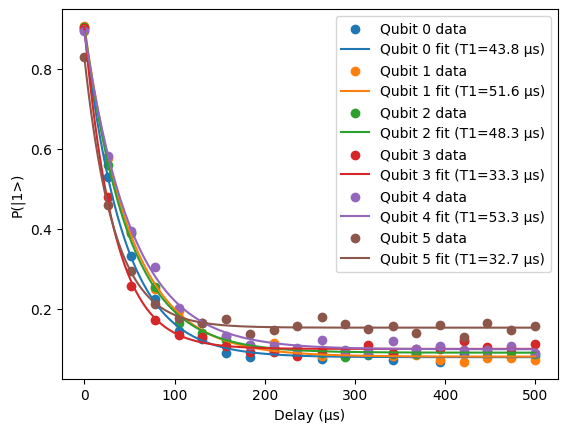

Qubit 0: T1 = 43.80 µs
Qubit 1: T1 = 51.62 µs
Qubit 2: T1 = 48.30 µs
Qubit 3: T1 = 33.29 µs
Qubit 4: T1 = 53.28 µs
Qubit 5: T1 = 32.72 µs


In [2]:
# load results
data = pd.read_csv("data/t1_results2.csv")

# define the exponential model
def exp_decay(t, A, T1, B):
    return A * np.exp(-t / T1) + B

t1_values = {}

for qubit in data["qubit"].unique():
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guesses: A=1, T1=100, B=0
    popt, pcov = curve_fit(exp_decay, t, p1, p0=[1.0, 100.0, 0.0])
    A, T1, B = popt
    t1_values[qubit] = T1
    
    # plot fit
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1, label=f"Qubit {qubit} data")
    plt.plot(t_fit, exp_decay(t_fit, *popt), label=f"Qubit {qubit} fit (T1={T1:.1f} µs)")

plt.xlabel("Delay (µs)")
plt.ylabel("P(|1>)")
plt.legend()
plt.show()

# print extracted T1s
for q, T1 in t1_values.items():
    print(f"Qubit {q}: T1 = {T1:.2f} µs")

### **2. $T_2^*$ measurements**

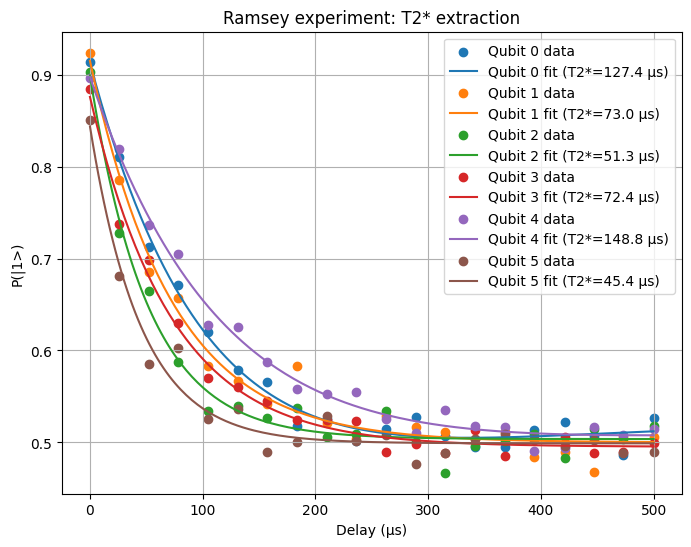

Qubit 0: T2* = 127.44 µs
Qubit 1: T2* = 73.04 µs
Qubit 2: T2* = 51.29 µs
Qubit 3: T2* = 72.44 µs
Qubit 4: T2* = 148.76 µs
Qubit 5: T2* = 45.38 µs


In [3]:
data = pd.read_csv("data/t2_results2.csv")

# --- Define exponential decay function for Ramsey (centered at 0.5) ---
def ramsey_osc(t, A, B, T2, Delta, phi):
    return A + B * np.sin(2*np.pi*Delta*t + phi) * np.exp(-t/T2)


# Dictionary to store T2* for each qubit
t2_values = {}

plt.figure(figsize=(8,6))

for qubit in data["qubit"].unique():
    qubit_data = data[data["qubit"] == qubit]
    t = qubit_data["delay_us"].values
    p1 = qubit_data["p1"].values
    
    # initial guess: A=0.5, T2=100, B=0.5
    popt, pcov = curve_fit(
        ramsey_osc, t, p1, 
        p0=[0.5, 0.5, 200, 0.001, 0],   # better initial guesses
        bounds=([0, 0, 0, 0, -np.pi], [1, 1, np.inf, 0.1, np.pi])
    )
    A, B, T2, Delta, phi = popt
    t2_values[qubit] = T2
    
    # smooth fit line
    t_fit = np.linspace(min(t), max(t), 200)
    plt.scatter(t, p1, label=f"Qubit {qubit} data")
    plt.plot(t_fit, ramsey_osc(t_fit, *popt), label=f"Qubit {qubit} fit (T2*={T2:.1f} µs)")

plt.xlabel("Delay (µs)")
plt.ylabel("P(|1>)")
plt.title("Ramsey experiment: T2* extraction")
plt.legend()
plt.grid(True)
plt.show()

# print extracted T2* values
for q, T2 in t2_values.items():
    print(f"Qubit {q}: T2* = {T2:.2f} µs")

## **Low period circuit.**

### **3. Error distributions.**

In [4]:
bits, rep, init, backend, extra = read_data("data/results_fakeqmio.txt")

In [5]:
print("Bitstrings:", bits[:5])     # first 5 measured states
print("Repetition period:", rep)
print("Init state:", init)
print("Backend:", backend)
print("Batch IDs:", extra.get("batch"))
print("Shot IDs:", extra.get("shot"))
print("Abs times:", extra.get("abstime"))


Bitstrings: ['111111' '111101' '111101' '011110' '111111']
Repetition period: 1.5e-05
Init state: None
Backend: qmio
Batch IDs: [  1   1   1 ... 815 815 815]
Shot IDs: [      1       2       3 ... 6676478 6676479 6676480]
Abs times: [1.50000000e-05 3.00000000e-05 4.50000000e-05 ... 1.00147170e+02
 1.00147185e+02 1.00147200e+02]


In [6]:
errors_obj = ErrorAnalyzer(repetition_period = rep, init_state = init, measurements = bits, verbose=2)
errors_dict = errors_obj.get_errors()

The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




In [7]:
states = errors_dict["low_period_errors"]["states"]
expected = errors_dict["low_period_errors"]["expected"]
true_errors = errors_dict['low_period_errors']['true_errors']
false_errors = errors_dict['low_period_errors']['false_errors']
total_errors = errors_dict['low_period_errors']['total_errors']
times = errors_dict['low_period_errors']['times']


print('number of true errors:',sum(true_errors))
print('number of false errors:',sum(false_errors))
print('number of total errors:',sum(total_errors))


number of true errors: 30754101
number of false errors: 642171
number of total errors: 31396272


In [8]:
print(times[:5], times[-5:])
print(extra.get("abstime")[1:5], extra.get("abstime")[-5:])

[0.0, 1.5e-05, 3e-05, 4.5e-05, 6e-05] [100.14711, 100.147125, 100.14714000000001, 100.147155, 100.14717]
[3.0e-05 4.5e-05 6.0e-05 7.5e-05] [100.14714  100.147155 100.14717  100.147185 100.1472  ]


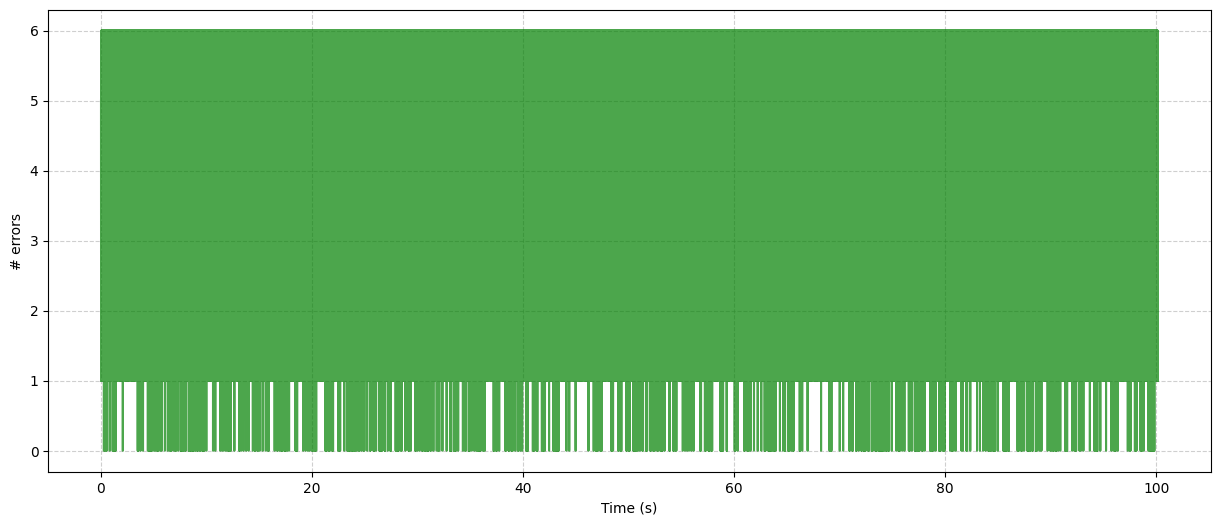

In [9]:
plt.figure(figsize=(15,6))
plt.plot(times, total_errors, '-', color = 'green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("# errors")
plt.grid(True, linestyle='--', alpha=0.6)

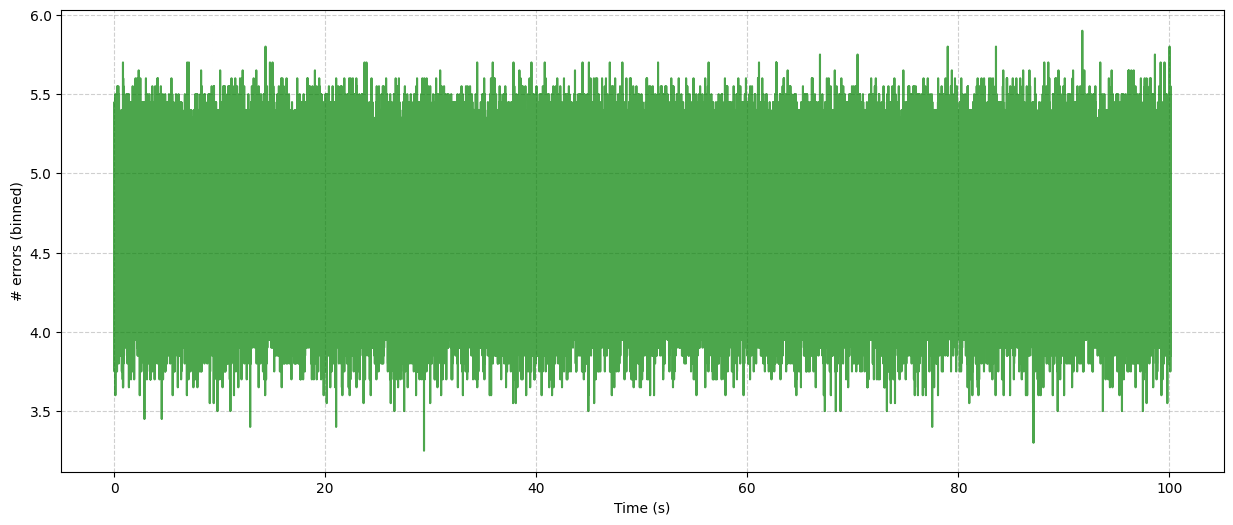

In [10]:
# Example: group every 6 points
bin_size = 20

# convert to arrays
times = np.array(times)
total_errors = np.array(total_errors)

# number of full bins
n_bins = len(total_errors) // bin_size

# reshape and take mean
binned_times = times[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)
binned_errors = total_errors[:n_bins*bin_size].reshape(n_bins, bin_size).mean(axis=1)

# plot
plt.figure(figsize=(15,6))
plt.plot(binned_times, binned_errors, '-', color='green', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("# errors (binned)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

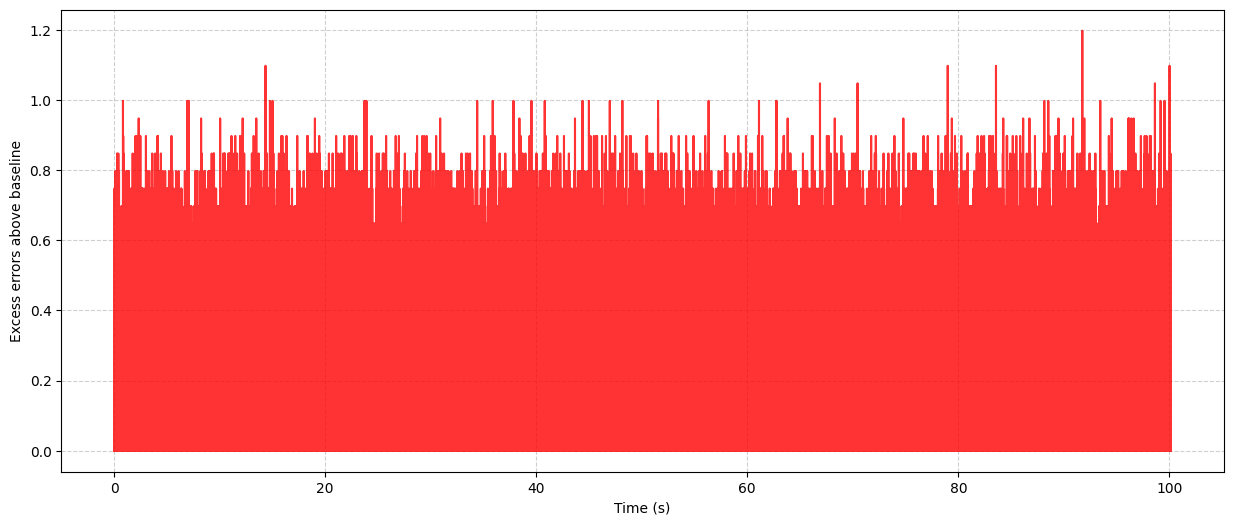

In [11]:
# assume binned_times, binned_errors from previous step
# ---------------- BASELINE ----------------
baseline = np.mean(binned_errors)  # or np.median(binned_errors)
signal = binned_errors - baseline  # subtract baseline

# optionally clip negatives to zero (if you only care about positive peaks)
signal = np.clip(signal, 0, None)

# ---------------- PLOT ----------------
plt.figure(figsize=(15,6))
plt.plot(binned_times, signal, '-', color='red', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Excess errors above baseline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [12]:
# ---------------- PARAMETERS ----------------
threshold = 1.75
window_before = 0.1  # seconds
window_after  = 0.3  # seconds

# ---------------- FIND PEAKS ON BINNED SIGNAL ----------------
peak_indices = np.where(signal > threshold)[0]

# avoid duplicates if consecutive bins are above threshold
selected_peaks = []
for idx in peak_indices:
    if not selected_peaks or (idx - selected_peaks[-1]) > 1:
        selected_peaks.append(idx)

print(f"Found {len(selected_peaks)} candidate peaks")

# ---------------- EXTRACT FROM RAW DATA ----------------
for peak_idx in selected_peaks:
    t_peak = binned_times[peak_idx]
    
    # define window in raw times
    t_min = t_peak - window_before
    t_max = t_peak + window_after
    
    # mask on raw data
    mask = (times >= t_min) & (times <= t_max)
    
    # plot raw errors around peak
    plt.figure(figsize=(10,4))
    plt.plot(times[mask], total_errors[mask], 'o-', color='purple')
    plt.axhline(np.mean(total_errors), color='gray', linestyle='--', alpha=0.7, label="mean noise")
    plt.axvline(t_peak, color='black', linestyle=':', label="peak")
    plt.xlabel("Time (s)")
    plt.ylabel("# errors (raw)")
    plt.title(f"Raw errors around peak at t = {t_peak:.3f} s - Index: {peak_idx}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Found 0 candidate peaks


The analysis was performed using the *low repetition period* approach 
(repetition_period < 5e-10 μs). The error dictionary contains:

- Key: 'low_period_errors' → A dictionary with 6676479 measurements with the following subkeys:
  - 'true_errors': Array with the number of true errors (0 expected, 1 measured) for each measurement.
  - 'false_errors': Array with the number of false errors (1 expected, 0 measured) for each measurement.
  - 'total_errors': Array with the total number of errors for each measurement.
  - 'times': Array with the times of each measurement (calculated as i * repetition_period).




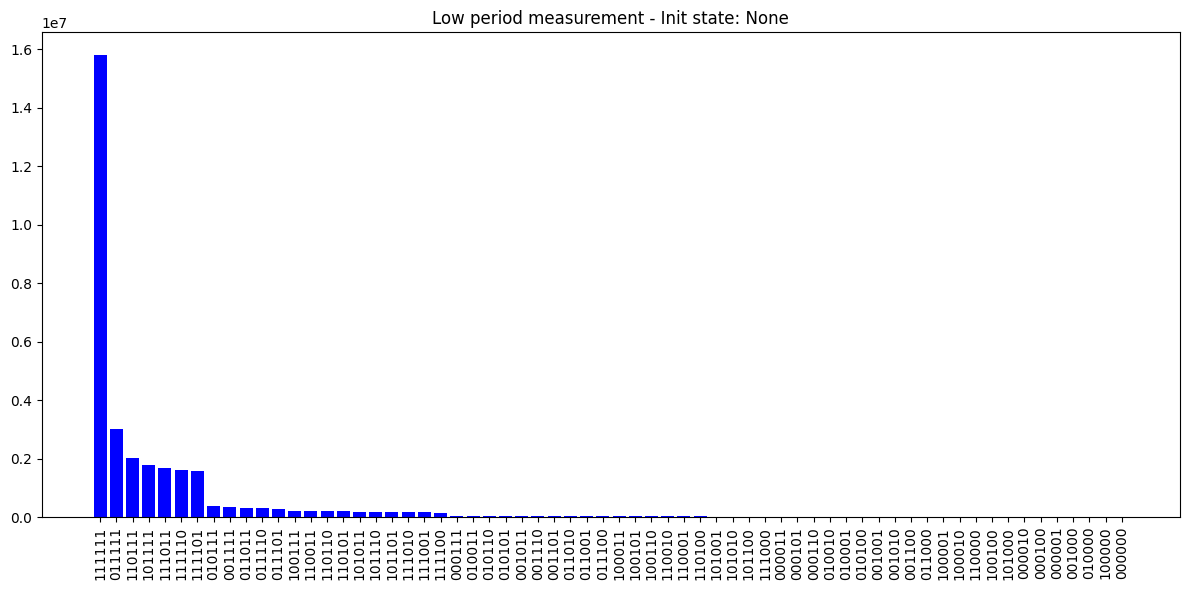

In [13]:
error_vis = ErrorVisualizer(error_obj=errors_obj)
period = "low"
labels, values = error_vis.get_states_histogram(period, obj=0)

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
error_vis.plot_histogram(labels, values, ax=ax1, title=f"{period.capitalize()} period measurement - Init state: {error_vis.init_state}")
plt.tight_layout()
plt.show()

[INFO] Bins before cut: 64
[INFO] Bins after cut: 64


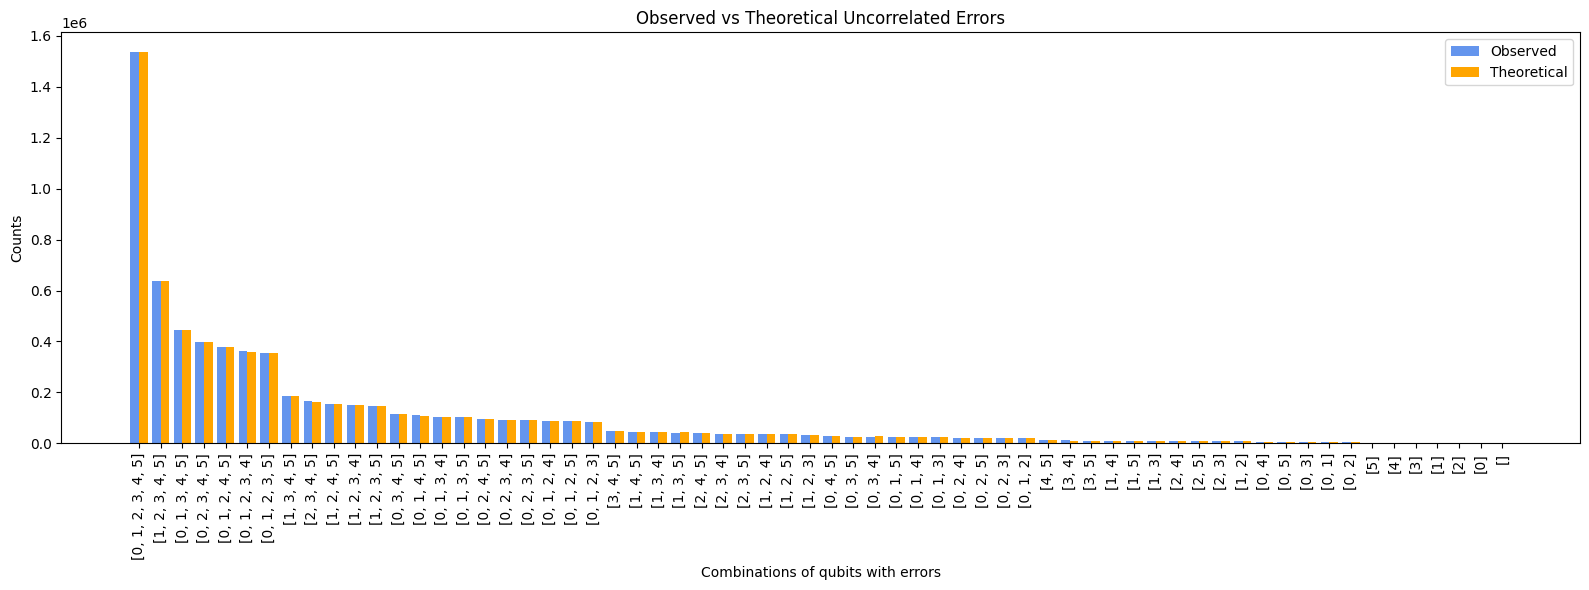

In [14]:
labels_both, observed_counts, theoretical_counts = error_vis.get_error_patterns(period, type="both", threshold=0.0)

# ---- Superposed Bar Plot ----
x = range(len(labels_both))
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar([i - width/2 for i in x], observed_counts, width=width, label="Observed", color = 'cornflowerblue')
plt.bar([i + width/2 for i in x], theoretical_counts, width=width, label="Theoretical", color = 'orange')
plt.xticks(x, labels_both, rotation=90)
plt.xlabel("Combinations of qubits with errors")
plt.ylabel("Counts")
plt.title("Observed vs Theoretical Uncorrelated Errors")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
total_errors, true_errors, false_errors = error_vis.get_error_counts(period)

True errors: If a 0 measurement is expected and instead we measure a 1.
False errors:  If a 1 measurement is expected and instead we measure a 0.
Number of true errors: 30754101
Number of false errors 642171


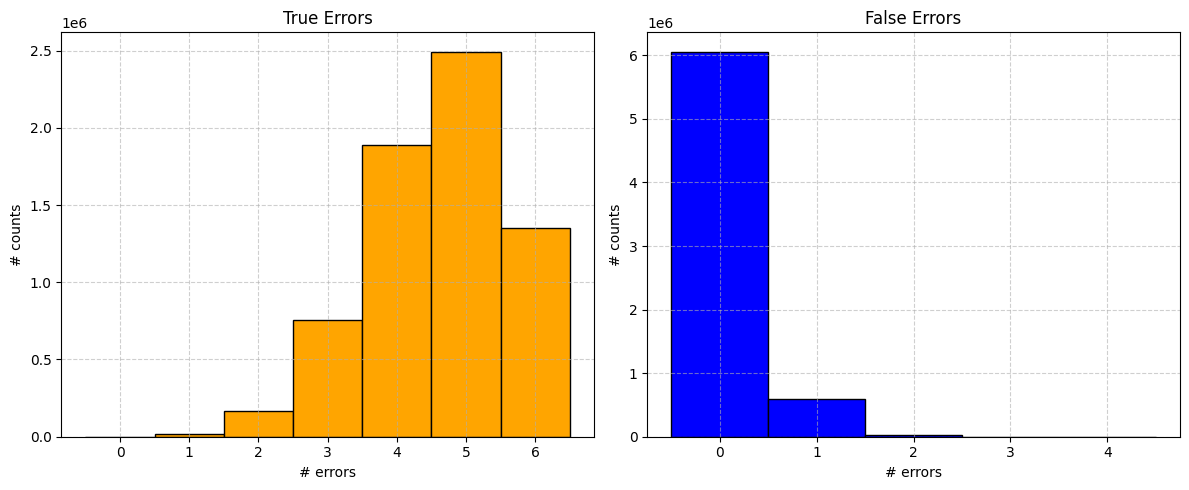

In [16]:
print("True errors: If a 0 measurement is expected and instead we measure a 1.")
print("False errors:  If a 1 measurement is expected and instead we measure a 0.")

print('Number of true errors:',sum(true_errors))
print('Number of false errors', sum(false_errors))

plt.figure(figsize=(12, 5))

    # Histograma de True Errors
plt.subplot(1, 2, 1)
plt.hist(true_errors, bins=range(max(true_errors)+2), edgecolor='black', align='left', color='orange')
plt.title("True Errors")
plt.xlabel("# errors")
plt.ylabel("# counts")
plt.grid(True, linestyle="--", alpha=0.6)

    # Histograma de False Errors
plt.subplot(1, 2, 2)
plt.hist(false_errors, bins=range(max(false_errors)+2), edgecolor='black', align='left', color='blue')
plt.title("False Errors")
plt.xlabel("# errors")
plt.ylabel("# counts")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

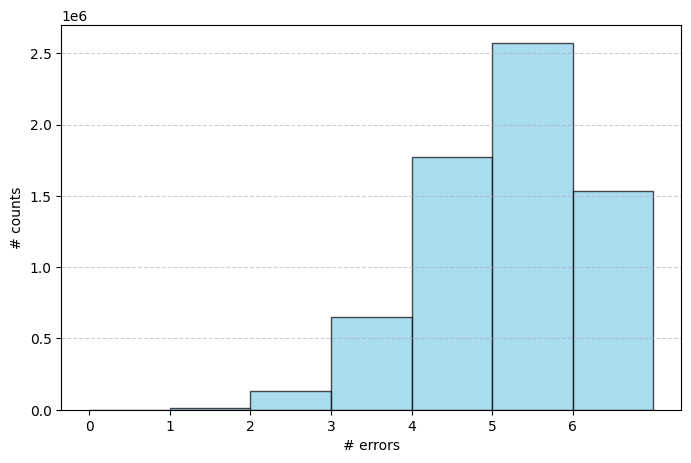

In [17]:
plt.figure(figsize=(8,5))
plt.hist(total_errors, bins=range(min(total_errors), max(total_errors) + 2), color='skyblue', alpha=0.7, edgecolor='black')
plt.xlabel("# errors")
plt.ylabel("# counts")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(range(min(total_errors), max(total_errors) + 1))  # Asegurar que los ticks sean enteros
plt.show()

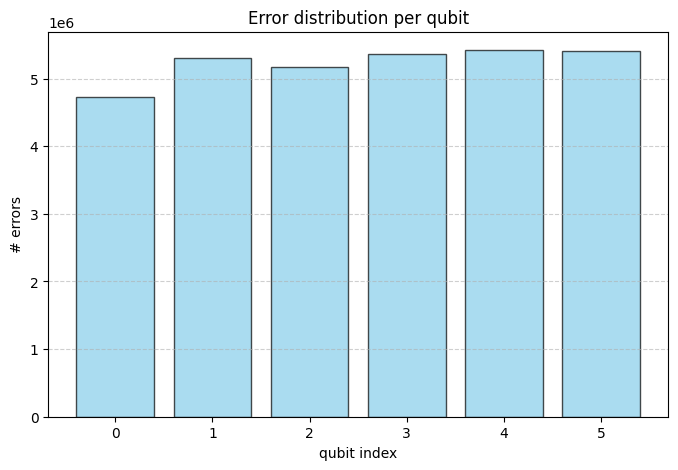

In [18]:
errors_per_qubit = errors_dict["low_period_errors"]["errors_per_qubit"]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(range(len(errors_per_qubit)), errors_per_qubit, color='skyblue', alpha=0.7, edgecolor='black')

# Etiquetas
plt.xlabel("qubit index")
plt.ylabel("# errors")
plt.title("Error distribution per qubit")
plt.xticks(range(len(errors_per_qubit)))  # Marcamos los qubits en el eje X
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()